In [1]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import ast

In [2]:
movies_df = pd.read_csv('movies_with_keywords.csv')

# convert keywords column to a list of keywords per movie
def extract_keywords(row):
    if pd.notnull(row['keywords']):
        keywords_list = ast.literal_eval(row['keywords'])
        return [keyword['name'] for keyword in keywords_list]
    else:
        return []

movies_df['keywords'] = movies_df.apply(extract_keywords, axis=1)


In [3]:
print(movies_df['keywords'].apply(lambda x: len(x)).describe())
print(movies_df['keywords'].explode().value_counts())

count    46479.000000
mean         3.418813
std          4.670947
min          0.000000
25%          0.000000
50%          2.000000
75%          5.000000
max        149.000000
Name: keywords, dtype: float64
keywords
woman director      3119
independent film    1934
murder              1310
based on novel       836
musical              734
                    ... 
longest film           1
figher airplane        1
all girl               1
chiropractor           1
acab                   1
Name: count, Length: 19956, dtype: int64


In [4]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
keyword_matrix = mlb.fit_transform(movies_df['keywords'])

In [5]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

kmeans = KMeans(n_clusters=5)
kmeans.fit(keyword_matrix)

pca = PCA(n_components=2)
pca_keyword_matrix = pca.fit_transform(keyword_matrix)

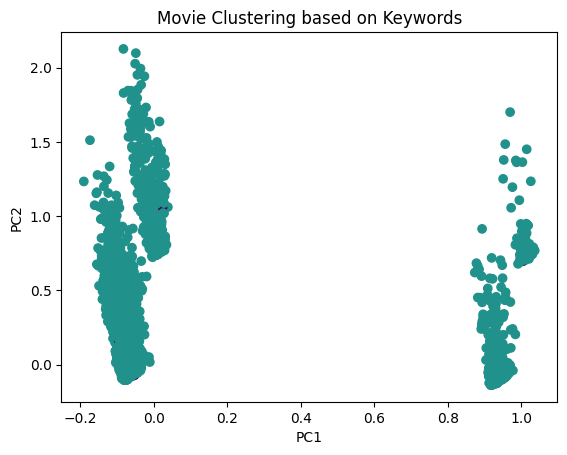

In [6]:
import matplotlib.pyplot as plt

plt.scatter(pca_keyword_matrix[:, 0], pca_keyword_matrix[:, 1], c=kmeans.labels_)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Movie Clustering based on Keywords')

plt.show()

In [7]:
# binary matrix of movies vs. keywords
mlb = MultiLabelBinarizer()
keyword_matrix = mlb.fit_transform(movies_df['keywords'])

In [8]:
# create a user profile
def create_user_profile(user_ratings):
    # initialize a user profile as a zero-vector with same dimension as the matrix
    user_profile = np.zeros(keyword_matrix.shape[1])

    # look at user's rating scores, each rating is a dictionary value (movieId - key, rating - value) (movieId: rating, ...)
    for movie_id, rating in user_ratings.items():
        # To the profile add a keyword vector for a movie scaled by the user's rating
        user_profile += keyword_matrix[movie_id] * rating

    # normalize by dividing profile by the sum of the ratings
    return user_profile / sum(user_ratings.values())

# generate recommendations function
def generate_recommendations(user_profile, num_recs=8):
    # calculate cosine similarity between the user profile and movie keywords
    similarity_scores = cosine_similarity(user_profile.reshape(1, -1), keyword_matrix)
    # get indices of the most similar movies (decending)
    recs = np.argsort(-similarity_scores[0])[:num_recs]
    # return the top recommended movie IDs
    return recs

In [9]:
# USE THE SYSTEM

# user_ratings = {movieId: rating, ...}
user_ratings = {862: 5, 15602: 4, 949: 3, 168: 4} # example values to test
user_profile = create_user_profile(user_ratings)
recs = generate_recommendations(user_profile)
print(recs)

[15602   168 10024 15578  5669 10147 17393  7993]


In [10]:
recs

array([15602,   168, 10024, 15578,  5669, 10147, 17393,  7993],
      dtype=int64)

In [11]:
# recommended movie IDs link to their index values
rec_indices = movies_df.index[movies_df['id'].isin(recs)]

# check the titles of the recommended movies based on index with matching id
recommended_movies = movies_df.loc[rec_indices, 'title']

# will print out the movie title if the id exists in the file, the number is the index of where the movie is
print(recommended_movies)

2                     Grumpier Old Men
1330     Star Trek IV: The Voyage Home
6816                         Bad Santa
13890               My Sister's Keeper
Name: title, dtype: object


In [12]:
movie_id = 168     
title = movies_df.loc[movies_df['id'] == movie_id, 'title'].values[0]
print(f"Movie ID {movie_id} is: {title}")

Movie ID 168 is: Star Trek IV: The Voyage Home
